# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [0]:
import tensorflow as tf
import csv
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import Sequence, np_utils
from keras.backend import epsilon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

### Change directory

In [0]:
project_path = '/gdrive/My Drive/Colab Notebooks/Lab and Assignments 9th/'

total 4
drwx------ 12 root root 4096 Jun 30 11:50 'My Drive'/


### Load the training data from train.csv file

In [0]:
train= pd.read_csv(project_path+'train_labels.csv')

### Print the shape of the train dataset

In [15]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128
image_width =128
image_height =128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [18]:
train.head(4)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298


In [19]:
train.dtypes

filename    object
width        int64
height       int64
class       object
xmin         int64
ymin         int64
xmax         int64
ymax         int64
dtype: object

In [0]:
filename = train['filename']

In [0]:
path = []
for name in filename:
    path = project_path +'images/' + filename
    path.append(path)

In [30]:
path[1]

'/gdrive/My Drive/Colab Notebooks/Lab and Assignments 9th/images/raccoon-11.jpg'

In [31]:
coords = np.zeros((len(path), 4))
coords.shape

(173, 4)

In [24]:
train.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [32]:
train.loc[0,'width']

259

In [0]:
for i in range(0,len(path)):
    image_width=train.loc[i,'width'].astype('int32')
    image_height=train.loc[i,'height'].astype('int32')
    x0=train.loc[i,'xmin'].astype('int32')
    y0=train.loc[i,'ymin'].astype('int32')
    x1=train.loc[i,'xmax'].astype('int32')
    y1=train.loc[i,'ymax'].astype('int32')
    coords[i, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[i, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
    coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height # Normalize bounding box by image size

In [34]:
coords[172,3]

66.44808743169399

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

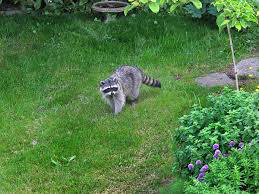

In [43]:
Image.open(path[0])

In [46]:
batch_images[0].shape

(128, 128, 3)

In [0]:
batch_images = np.zeros((len(path), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i in range(0,len(path)):
    img = Image.open(path[i]) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [47]:
batch_images.shape

(173, 128, 128, 3)

W0630 12:09:49.953420 139945548048256 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


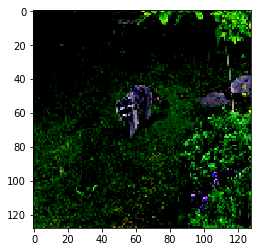

In [48]:
plt.imshow(batch_images[0])
plt.show()

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [49]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

W0630 12:09:55.077832 139945548048256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 12:09:55.127844 139945548048256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 12:09:55.137867 139945548048256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 12:09:55.174185 139945548048256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 12:09:55.175405 1399455480

17227776/17225924 [==============================] - 1s 0us/step


In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [53]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.fit(batch_images,gt,epochs=30,batch_size = 32,verbose=1)

W0630 12:10:20.987133 139945548048256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0630 12:10:21.020562 139945548048256 deprecation.py:323] From <ipython-input-52-a811784d62ce>:25: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable,

Epoch 1/30
173/173 [==============================] - 4s 24ms/step - loss: 2919.3271 - IoU: 0.0794
Epoch 2/30
173/173 [==============================] - 0s 590us/step - loss: 674.5820 - IoU: 0.4267
Epoch 3/30
173/173 [==============================] - 0s 565us/step - loss: 656.1467 - IoU: 0.5392
Epoch 4/30
173/173 [==============================] - 0s 580us/step - loss: 602.1443 - IoU: 0.5214
Epoch 5/30
173/173 [==============================] - 0s 586us/step - loss: 342.2254 - IoU: 0.5897
Epoch 6/30
173/173 [==============================] - 0s 576us/step - loss: 303.4753 - IoU: 0.5679
Epoch 7/30
173/173 [==============================] - 0s 556us/step - loss: 261.3395 - IoU: 0.5812
Epoch 8/30
173/173 [==============================] - 0s 567us/step - loss: 201.5261 - IoU: 0.6526
Epoch 9/30
173/173 [==============================] - 0s 588us/step - loss: 173.3634 - IoU: 0.6996
Epoch 10/30
173/173 [==============================] - 0s 578us/step - loss: 156.3225 - IoU: 0.7165
Epoch 11/

### Pick a test image from the given data

In [0]:
unscaled=Image.open(path[14])

In [62]:
unscaled.size

(236, 314)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
scaled=unscaled.resize((128, 128))

In [0]:
scaled=preprocess_input(np.array(scaled, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

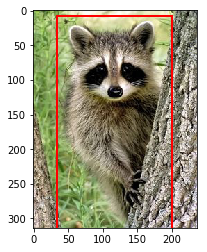

In [66]:
image_width,image_height = unscaled.size
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

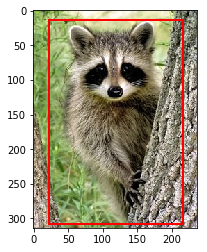

In [69]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
unscaled=Image.open(path[14])
ax.imshow(unscaled)

# Create a Rectangle patch
x0=train.loc[14,'xmin'].astype('int32')
y0=train.loc[14,'ymin'].astype('int32')
x1=train.loc[14,'xmax'].astype('int32')
y1=train.loc[14,'ymax'].astype('int32')
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

### Load your data file

In [0]:
df= pd.read_csv(project_path+'daily-minimum-temperatures-in-me.csv')

In [72]:
df.shape

(3650, 2)

In [75]:
df.head(5)

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

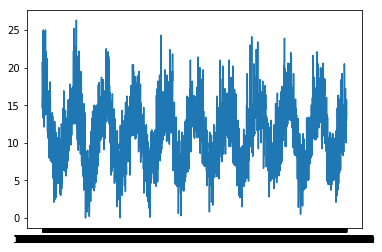

In [76]:
plt.plot(df['Date'],df['Temperature'])

#### Descibe your dataframe

In [77]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [78]:
df.isna().count()

Date           3650
Temperature    3650
dtype: int64

#### Drop null values

In [0]:
df= df.dropna(axis=1)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44c6488390>]],
      dtype=object)

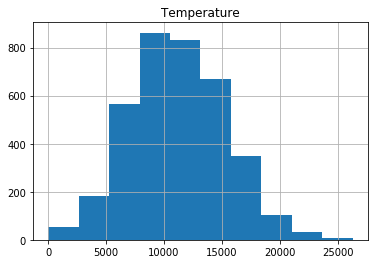

In [90]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [80]:
df['Temperature'].max()

26.3

In [81]:
df['Temperature'].min()

0.0

### Normalize the data

In [87]:
df.columns

Index(['Date', 'Temperature'], dtype='object')

In [89]:
# Data Cleansing
columns_to_keep = ['Temperature']
df = df[columns_to_keep]
df['Temperature'] = df['Temperature'].apply(lambda x: x*1000)
df.index.names = ['Date']
df.sort_index(inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 3650


,Temperature
Date,
0,20700.0
1,17900.0
2,18800.0
3,14600.0
4,15800.0


#### Check the maximum and minimum values of scaled data

In [0]:
dataset = df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Look into some of the scaled values

In [96]:
scaled[:10]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046],
       [0.60076046],
       [0.60076046],
       [0.66159696],
       [0.82889734],
       [0.76045627]])

### Split data into Training and Testing

In [94]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


#### Print train and test size

In [99]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [102]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


### Summarize your model

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [108]:
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/10
 - 11s - loss: 0.0103
Epoch 2/10
 - 11s - loss: 0.0103
Epoch 3/10
 - 11s - loss: 0.0103
Epoch 4/10
 - 11s - loss: 0.0103
Epoch 5/10
 - 11s - loss: 0.0101
Epoch 6/10
 - 11s - loss: 0.0101
Epoch 7/10
 - 11s - loss: 0.0102
Epoch 8/10
 - 11s - loss: 0.0103
Epoch 9/10
 - 11s - loss: 0.0103
Epoch 10/10
 - 11s - loss: 0.0103


## Make Predictions and Evaluate your model

In [109]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2597.67 RMSE
Test Score: 2420.47 RMSE


## Plot the results

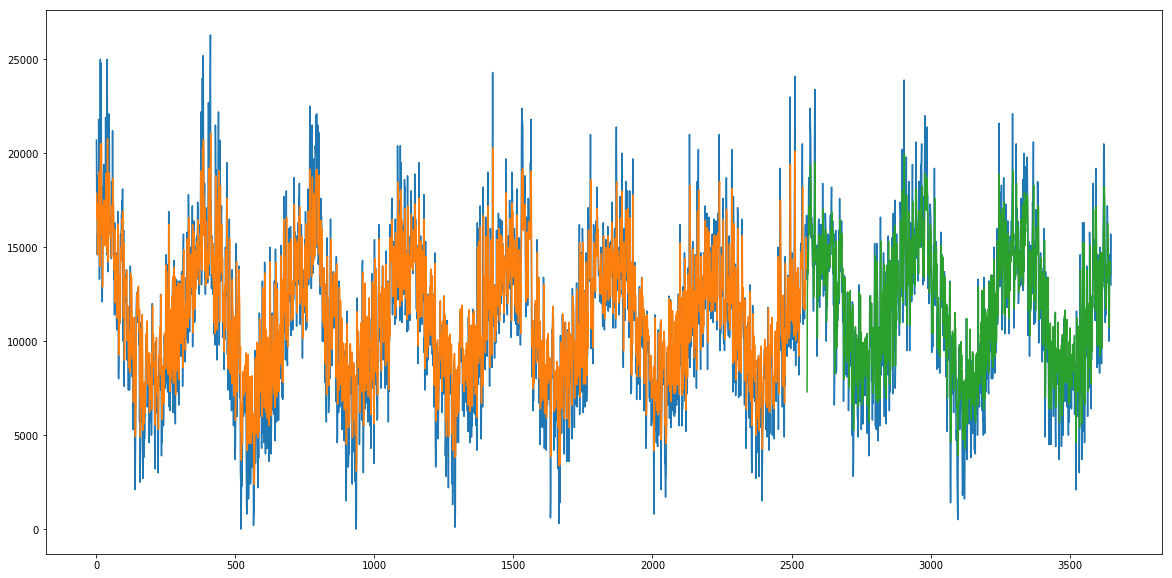

In [110]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()